In [1]:
import pandas as pd
import datetime as dt
from self_harm_triage_notes.config import data_interim_dir

# Pretty plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12

# Pandas settings
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100

___
# LVRH ED presentations

In [2]:
# Load data
lvrh = pd.read_parquet(data_interim_dir / "lvrh_2012_2022.parquet", engine="pyarrow")
print(lvrh.shape)
lvrh.head()

(380329, 11)


,uid,sex,age,arrival_method,arrival_date,year,triage_note,SH,SI,AOD_OD,audit_case
0,LVRH2-2012-1,Male,2,"OTHER (INCLUDES PRIVATE CAR, WALKED)",2012-01-01 00:06:00,2012,PT FELL OVER WHILST OUT CAMPING AT APPROX 2200HRS ONTO ?BROKEN GLASS. PT REFUSED PANADOL BY PARE...,0,0,0,0
1,LVRH2-2012-2,Female,53,"OTHER (INCLUDES PRIVATE CAR, WALKED)",2012-01-01 00:30:00,2012,PT PRESENTS WITH ?SOMETHING IN HER LEFT EYE. PT WAS AT HOME WHEN LEFT EYE BECAME ITCHY AT APPROX...,0,0,0,0
2,LVRH2-2012-3,Male,24,ROAD AMBULANCE SERVICE,2012-01-01 00:56:00,2012,BIBA POST WITTNESSED ASSAULT APPROX 2330HRS. HIT IN LEFT SIDE OF FACE AND HAD LOC ?LENGHT OF TIM...,0,0,0,0
3,LVRH2-2012-4,Male,21,"OTHER (INCLUDES PRIVATE CAR, WALKED)",2012-01-01 01:07:00,2012,"PAST WEEK HAS BEEN SMOKING MARIJUANA. 2/7 EAR ACHES , SORE THROAT AND HEADACHE . TODAY RASH ON L...",0,0,0,0
4,LVRH2-2012-5,Male,3,"OTHER (INCLUDES PRIVATE CAR, WALKED)",2012-01-01 01:12:00,2012,BIB FATHER WITH PAINFUL AND SWOLLEN PENIS. PT HAS BEEN AT BEACH TODAY AND AT APPROX 1500HRS STAR...,0,0,0,0


## General info

In [3]:
lvrh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380329 entries, 0 to 380328
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   uid             380329 non-null  object        
 1   sex             380329 non-null  object        
 2   age             380329 non-null  int64         
 3   arrival_method  380329 non-null  object        
 4   arrival_date    380329 non-null  datetime64[ns]
 5   year            380329 non-null  int64         
 6   triage_note     380329 non-null  object        
 7   SH              380329 non-null  int64         
 8   SI              380329 non-null  int64         
 9   AOD_OD          380329 non-null  int64         
 10  audit_case      380329 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 31.9+ MB


In [4]:
lvrh.isna().sum()

uid               0
sex               0
age               0
arrival_method    0
arrival_date      0
year              0
triage_note       0
SH                0
SI                0
AOD_OD            0
audit_case        0
dtype: int64

In [5]:
lvrh.nunique()

uid               380329
sex                    4
age                  108
arrival_method        16
arrival_date      371008
year                  11
triage_note       379412
SH                     2
SI                     2
AOD_OD                 2
audit_case             2
dtype: int64

## Data checks

In [6]:
# Check the year was extracted correctly
assert (lvrh.arrival_date.dt.year == lvrh.year).all()

In [7]:
# Empty triage notes
print("The dataset contains %d presentations with empty triage notes." % 
      lvrh.triage_note.isna().sum())
# Triage note containing only "\n"
print("The dataset contains %d presentations containing only newline." % 
      (lvrh.triage_note.str.lower()==" \n").sum())
# Triage note stating "as above"
print("The dataset contains %d presentations stating \"as above\"." % 
      (lvrh.triage_note.str.lower()=="as above").sum())

The dataset contains 0 presentations with empty triage notes.
The dataset contains 72 presentations containing only newline.
The dataset contains 0 presentations stating "as above".


### Number of presentations over time

In [8]:
# Expected range of dates
count_per_day = pd.DataFrame(index=pd.date_range(start='2012-01-01',end='2022-06-30'))
count_per_day['count'] = 0
# Update with actual counts
count_per_day.update({'count': lvrh.groupby(lvrh.arrival_date.dt.date).size()})

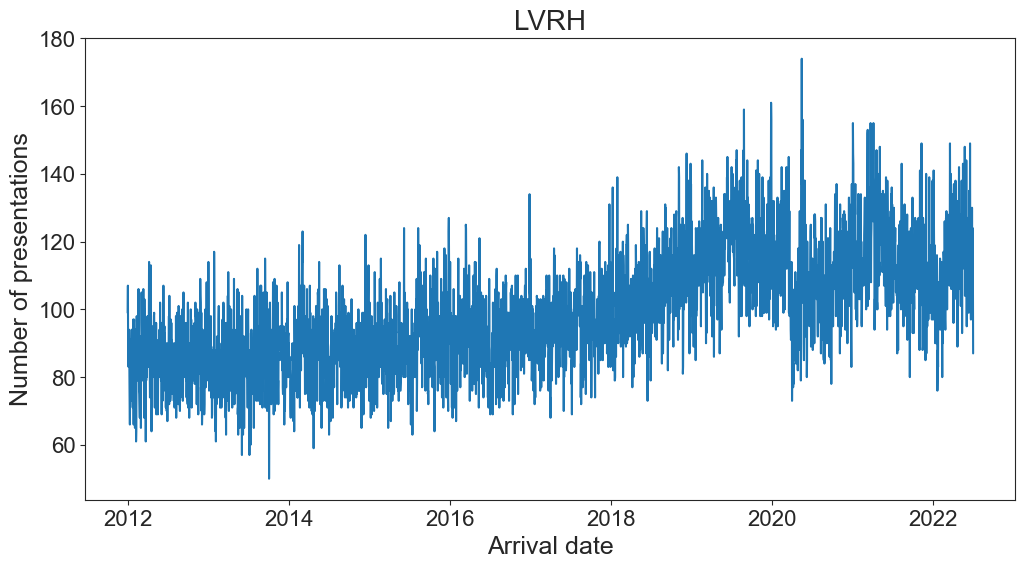

In [9]:
plt.rcParams['figure.figsize'] = (12, 6)

sns.lineplot(x=count_per_day.index,
             y=count_per_day['count']);

plt.xlabel("Arrival date");
plt.ylabel("Number of presentations");
plt.title("LVRH");
# plt.savefig("../results/number of presentations.jpeg", dpi=300, pad_inches=0);

In [10]:
lvrh.arrival_date.dt.date.value_counts().tail(10)

arrival_date
2013-03-22    63
2013-07-12    62
2013-02-04    61
2012-03-23    61
2012-02-08    61
2013-07-11    60
2014-04-23    59
2013-07-06    57
2013-06-02    57
2013-10-03    50
Name: count, dtype: int64

In [11]:
# Data missing between 22 Dec 2015 and 31 Dec 2015 inclusive
lvrh[(lvrh.arrival_date.dt.date >= dt.date(2015, 12, 15)) & 
   (lvrh.arrival_date.dt.date <= dt.date(2016, 1, 5))].arrival_date.dt.date.value_counts().sort_index()

arrival_date
2015-12-15     92
2015-12-16     74
2015-12-17     87
2015-12-18     81
2015-12-19     90
2015-12-20     91
2015-12-21    105
2015-12-22    105
2015-12-23     74
2015-12-24     70
2015-12-25     88
2015-12-26    123
2015-12-27    127
2015-12-28    112
2015-12-29    101
2015-12-30    102
2015-12-31     90
2016-01-01    106
2016-01-02    114
2016-01-03     95
2016-01-04     99
2016-01-05     78
Name: count, dtype: int64

In [12]:
# Lower than usual number of cases on 28-29 Jun 2019
lvrh[(lvrh.arrival_date.dt.date >= dt.date(2019, 6, 25)) & 
   (lvrh.arrival_date.dt.date <= dt.date(2019, 7, 5))].arrival_date.dt.date.value_counts().sort_index()

arrival_date
2019-06-25    119
2019-06-26    119
2019-06-27    132
2019-06-28    128
2019-06-29    132
2019-06-30    121
2019-07-01    142
2019-07-02    120
2019-07-03    134
2019-07-04    132
2019-07-05    127
Name: count, dtype: int64

In [13]:
# Lower than usual number of cases on 24 Aug 2021
lvrh[(lvrh.arrival_date.dt.date >= dt.date(2021, 8, 20)) & 
   (lvrh.arrival_date.dt.date <= dt.date(2021, 8, 30))].arrival_date.dt.date.value_counts().sort_index()

arrival_date
2021-08-20    112
2021-08-21    122
2021-08-22    111
2021-08-23    131
2021-08-24     98
2021-08-25    108
2021-08-26    115
2021-08-27    103
2021-08-28    105
2021-08-29    111
2021-08-30    122
Name: count, dtype: int64

In [14]:
lvrh.arrival_date.dt.date.value_counts().head(10)

arrival_date
2020-05-14    174
2019-12-27    161
2019-08-26    159
2019-12-28    156
2020-05-18    156
2021-04-04    155
2021-03-22    155
2021-01-01    155
2021-03-09    153
2021-03-08    152
Name: count, dtype: int64

In [15]:
# Higher than usual number of cases on 21 Nov 2016
lvrh[(lvrh.arrival_date.dt.date >= dt.date(2016, 11, 15)) & 
   (lvrh.arrival_date.dt.date <= dt.date(2016, 11, 30))].arrival_date.dt.date.value_counts().sort_index()

arrival_date
2016-11-15     88
2016-11-16    101
2016-11-17     98
2016-11-18     82
2016-11-19     91
2016-11-20    104
2016-11-21     98
2016-11-22     96
2016-11-23     85
2016-11-24     96
2016-11-25     87
2016-11-26     85
2016-11-27     83
2016-11-28     95
2016-11-29     95
2016-11-30    103
Name: count, dtype: int64

In [16]:
count_per_day[count_per_day['count'] >= 400]

,count


### Annotations

In [17]:
# Check for confusion between SH, SI, and AOD OD
print("Number of presentations annotated as both SH and SI:", ((lvrh.SH==1) & (lvrh.SI==1)).sum())
print("Number of presentations annotated as both SH and AOD OD:", ((lvrh.SH==1) & (lvrh.AOD_OD==1)).sum())
print("Number of presentations annotated as both SI and AOD OD:", ((lvrh.SI==1) & (lvrh.AOD_OD==1)).sum())

Number of presentations annotated as both SH and SI: 2
Number of presentations annotated as both SH and AOD OD: 0
Number of presentations annotated as both SI and AOD OD: 0


In [18]:
# Patients under the age of 9 with positive labels
print("Number of presentation annotated as SH from patients under the age of 9:", ((lvrh.SH==1) & (lvrh.age<9)).sum())
print("Number of presentation annotated as SI from patients under the age of 9:", ((lvrh.SI==1) & (lvrh.age<9)).sum())
print("Number of presentation annotated as AOD from patients under the age of 9:", ((lvrh.AOD_OD==1) & (lvrh.age<9)).sum())

Number of presentation annotated as SH from patients under the age of 9: 28
Number of presentation annotated as SI from patients under the age of 9: 9
Number of presentation annotated as AOD from patients under the age of 9: 0


## Normalise data

### Sex

In [19]:
lvrh.sex.value_counts(dropna=False)

sex
Female           194151
Male             186175
-                     2
Indeterminate         1
Name: count, dtype: int64

In [20]:
# Normalise sex variable to 4 values (LVRH)
lvrh.sex = lvrh.sex.str.lower()
lvrh.loc[lvrh.sex.isin(["indeterminate"]), 'sex'] = "intersex"
lvrh.loc[~lvrh.sex.isin(["female", "male", "intersex"]), 'sex'] = "unknown"

categories = ["female", "male", "intersex", "unknown"]
lvrh.sex = lvrh.sex.astype('category').cat.set_categories(categories)

### Arrival method

In [21]:
lvrh.arrival_method.value_counts(dropna=False).head(15)

arrival_method
OTHER (INCLUDES PRIVATE CAR, WALKED)                                                                175915
Other                                                                                                95760
ROAD AMBULANCE SERVICE                                                                               64773
Road ambulance service                                                                               36382
Ambulance service- private ambulance car- hospital contracted                                         2332
AMBULANCE SERVICE - PRIV AMB CAR - HOSPITAL CONTRACTED                                                2291
POLICE VEHICLE                                                                                        1302
Ambulance service- private ambulance car- MAS/RAV contracted                                           833
Police vehicle                                                                                         348
-                     

In [22]:
def normalise_arrival_method(x):
    # Convert to lowercase
    x = x.str.lower()
    # Replace string values
    x.loc[x.fillna("").str.contains("community|self|walk-in|walked|public transport")] = "self/community/pt"
    x.loc[x.fillna("").str.contains("road ambulance")] = "road ambulance"
    x.loc[x.fillna("").str.contains("private|priv")] = "private ambulance"
    x.loc[x.fillna("").str.contains("air|helicopter")] = "air ambulance"
    x.loc[x.fillna("").str.contains("police")] = "police"
    x.loc[x.fillna("").str.contains("undertaker")] = "undertaker"
    x.loc[x.fillna("").str.contains("other")] = "other"
    x = x.astype('category').cat.set_categories(['self/community/pt', 'road ambulance', 
                                                 'private ambulance', 'air ambulance', 
                                                 'police', 'undertaker', 'other'])
    x.fillna("other", inplace=True)
    
    return x

# Normalise arrival method variable
lvrh.arrival_method = normalise_arrival_method(lvrh.arrival_method)

### Triage notes

In [23]:
# Replace single newline with empty string
lvrh.loc[lvrh.triage_note.str.lower()==" \n", 'triage_note'] = ""

### Annotations

In [24]:
# Fix annotation errors
# Two records annotated as both self-harm and Suicidal ideation overdose
lvrh.loc[(lvrh.SH==1) & (lvrh.SI==1), 'SH'] = 0

# 28 patients aged <9 positive for SH
lvrh.loc[(lvrh.age<9) & (lvrh.SH==1), 'SH'] = 0

# 9 patients aged <9 positive for SI
lvrh.loc[(lvrh.age<9) & (lvrh.SI==1), 'SI'] = 0

### Additional columns

In [25]:
# Create new column that contains quarter
lvrh['quarter'] = lvrh.arrival_date.dt.to_period('Q')

# Triage note length
lvrh['length'] = lvrh.triage_note.apply(len)

### Remove patients below the age of 9

In [26]:
# Remove presentations of patients under the age of 9
lvrh = lvrh[lvrh.age >= 9].copy()
lvrh.reset_index(drop=True, inplace=True)
lvrh.shape

(335209, 13)

### Save dataset

In [27]:
lvrh.to_parquet(data_interim_dir / "lvrh_2012_2022_cleaned.parquet", engine="pyarrow")

___
# EDA

In [28]:
# Remove 2022 (temporarily)
lvrh = lvrh[lvrh.year < 2022].copy()
lvrh.shape

(316877, 13)

### Number of presentations
**Per year**

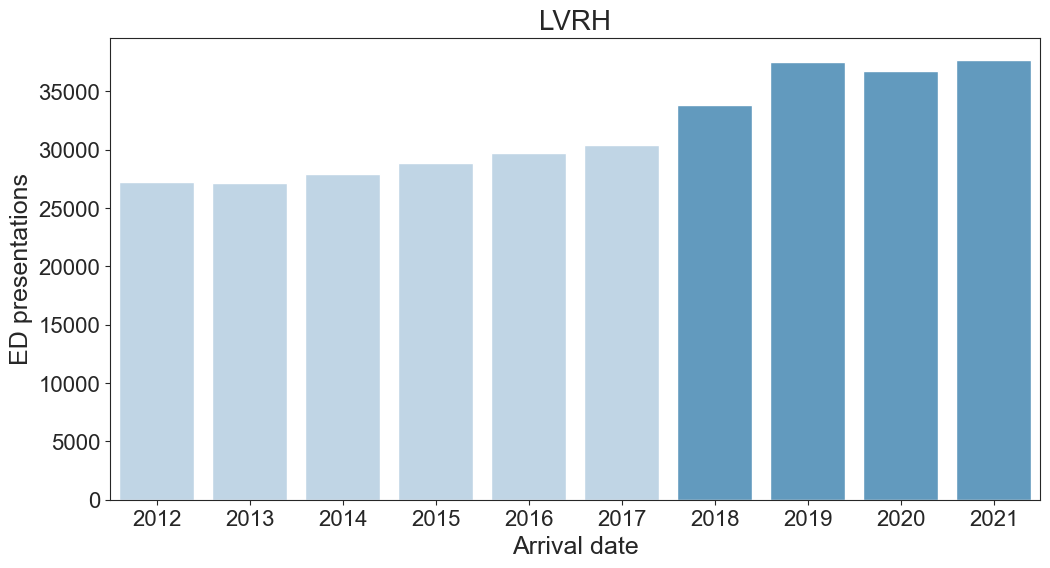

In [29]:
palette = {year: sns.color_palette('Blues')[1] for year in range(2012, 2018)}
palette.update({year: sns.color_palette('Blues')[3] for year in range(2018, 2022)})

sns.countplot(x='year', data=lvrh, hue='year', palette=palette, legend=False);
plt.xlabel("Arrival date");
plt.ylabel("ED presentations");
plt.title("LVRH");
plt.savefig("../results/LVRH presentations per year.jpeg", bbox_inches='tight', dpi=300);

In [30]:
lvrh.year.value_counts().agg(['mean', 'std']).round()

mean    31688.0
std      4326.0
Name: count, dtype: float64

**Per quarter**

In [31]:
lvrh.quarter.value_counts().agg(['mean', 'std']).round()

mean    7922.0
std     1060.0
Name: count, dtype: float64

### Age

In [32]:
lvrh.age.describe().round()

count    316877.0
mean         47.0
std          23.0
min           9.0
25%          26.0
50%          45.0
75%          66.0
max         119.0
Name: age, dtype: float64

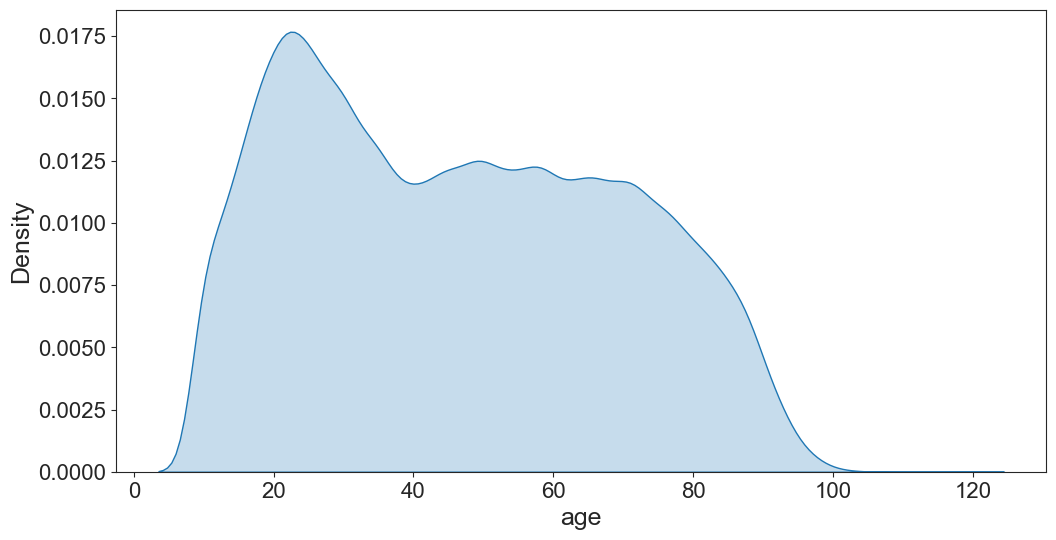

In [33]:
sns.kdeplot(x='age', data=lvrh, fill=True);

### Sex

In [34]:
lvrh.sex.value_counts(normalize=True)

sex
female      0.519558
male        0.480432
unknown     0.000006
intersex    0.000003
Name: proportion, dtype: float64

### Arrival method

In [35]:
lvrh.arrival_method.value_counts(normalize=True)

arrival_method
self/community/pt    0.466219
road ambulance       0.291419
other                0.220713
private ambulance    0.015908
police               0.005011
air ambulance        0.000729
undertaker           0.000000
Name: proportion, dtype: float64

### Length of triage notes

In [36]:
lvrh.length.describe().round()

count    316877.0
mean        277.0
std         126.0
min           0.0
25%         191.0
50%         261.0
75%         345.0
max        1555.0
Name: length, dtype: float64

### SH and SI

In [37]:
(lvrh.SH.value_counts(dropna=False, normalize=True) * 100).round(1)

SH
0    98.3
1     1.7
Name: proportion, dtype: float64

In [38]:
(lvrh.SI.value_counts(dropna=False, normalize=True) * 100).round(1)

SI
0    98.1
1     1.9
Name: proportion, dtype: float64